# Lindbladian calculation of cavity dephasing time 💣

In [1]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
plt.style.use('ggplot')
%matplotlib inline
sx = qt.sigmax()
sy = qt.sigmay()
sz = qt.sigmaz()
sm = qt.sigmam()
sp = qt.sigmap()
def I(x): return qt.qeye(x)

## 👉 What is the Lindblad master equation?
Normally, we evaluate the time evolution of a quantum system with the *Schrodinger equation*. Unfortunately, although it is *possible* to describe everything with the schrodinger equation, it is not always feasible to do so. Take, for example, interaction with the environment outside our experiment, we could model this interaction with the schrodinger equation but to do so we need to be able to model the quantum behaviour of the environment, and that is hard to impossible. A better approach is to use a *master equation* (the *Lindblad master equation*, to be precise), it allows usu to model the quantum dynamics of an open system, i.e. non-unitary operation on our quantum system. If we had, for example, a qubit that has some chance to collapse on the ground state every so often (non-coherently, that is) we could model such thing with the master equation.

This is the **Lindblad master equation** in it's full form:
$$\dot{\rho} = -\frac{i}{\hbar}[H,\rho] + \sum_{n,m=1}^{N^2-1} h_{nm}(A_n \rho A^\dagger_m - \frac{1}{2}\{A^\dagger_mA_n, \rho\})$$
But is better solved (for us) with it's diagonal form
$$\dot{\rho} = -\frac{i}{\hbar}[H,\rho] + \sum_{i=1}^{N^2-1} \gamma_i(L_i \rho L^\dagger_i - \frac{1}{2}\{L^\dagger_i L_i, \rho\})$$
Where $\gamma_i$ is the rate at which this process occurs and $L_i$ are the *Lindblad operators* (or *jump operators*),
$$L_i = \sum_{j=1}^{N^2-1}u_{ji}A_j$$
$u$ is the unitary transformation that diagnelizes $h$, i.e. $u^\dagger h u$ is a diagonal matrix

#### 🔹 Defining parameters

In [2]:
wc = 1.0  *2*np.pi  # cavity frequency
wa = 1.0  *2*np.pi  # atom frequency

g      = 0.05 *2*np.pi  # coupling strength
kappa  = 0.005          # cavity dissipation rate
gamma  = 0.1            # atom dissipation rate
N      = 15             # number of cavity fock states
n_th_a = 0.1            # avg number of thermal bath excitation

tlist  = np.linspace(0,100,1000)

#### 🔹 Defining Hamiltonian, initial state and operators

In [3]:
# intial state
psi0 = qt.tensor(qt.basis(N,0), qt.basis(2,1))

# operators
a  = qt.tensor(qt.destroy(N), qt.qeye(2))
sm = qt.tensor(qt.qeye(N), qt.destroy(2))

# Hamiltonian (no RWA) jayness cummings
H = wc * a.dag() * a + wa * sm.dag() * sm + g * (a.dag() + a) * (sm + sm.dag())
# H = wc * a.dag() * a + wa * sm.dag() * sm + g* a.dag()*a * sm.dag()*sm

#### 🔹 Defining collapse operators
Now this is the interesting part. Each operators in the list `c_ops` will be evaluated as if it's operation is occouring at some specified rate. So the third one, for example, the $\hat{\sigma}_z$ is responsible for qubit non-coherently relaxing.

In this test, these are the collapse operators:
  * **Cavity relaxation:** $\sqrt{K(1 + n_{th})} \hat{a} \rightarrow$               The cavity loses a photon due to thermal noise
  * **Cavity excitation:** $\sqrt{Kn_{th}} \hat{a}^\dagger \quad\ \ \ \rightarrow$  The cavity gains a photon due to thermal noise
  * **Qubit relaxation:** $\sqrt{\gamma} \hat{\sigma}_-\quad\quad\quad\rightarrow$  The atom collapses to the ground state

In [4]:
# collapse operators
c_ops = [
    np.sqrt(kappa*(1+n_th_a)) * a,    # cavity relaxation
    np.sqrt(kappa*n_th_a) * a.dag(),  # cavity excitation
    np.sqrt(gamma) * sm               # qubit relaxation
]

In [5]:
# Results. Heisenberg picture, project on photon number and "atom number"
output = qt.mesolve(H, psi0, tlist, c_ops, [a.dag()*a, sm.dag()*sm])

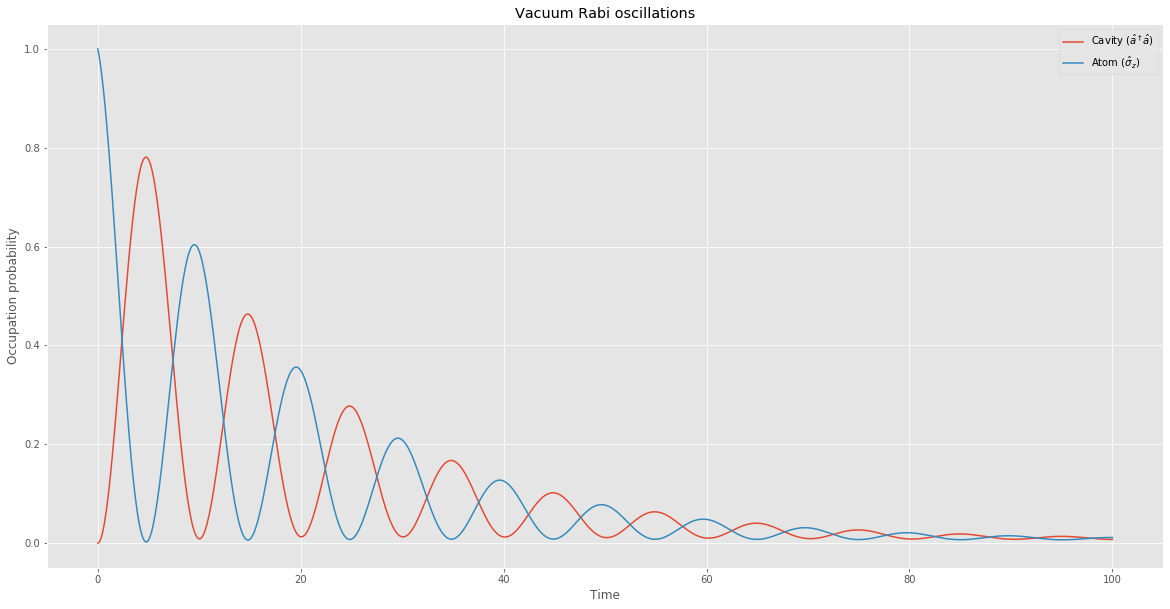

In [6]:
n_c = output.expect[0]
n_a = output.expect[1]

fig, axes = plt.subplots(figsize=(20,10))

axes.plot(tlist, n_c, label=r"Cavity ($\hat{a}^\dagger \hat{a}$)")
axes.plot(tlist, n_a, label=r"Atom ($\hat{\sigma}_z$)")
axes.legend(loc=0)
axes.set_xlabel('Time')
axes.set_ylabel('Occupation probability')
axes.set_title('Vacuum Rabi oscillations');

As expected, we get a decaying sinusoid. Now we want to find the life-time of the qubit, to do so we need to fit this results to find the envelope of the decay. We'll fit the results with a general exponential multiplied by a sinusoid. 

In [7]:
def sinexp(x, w, r, A):
    return A*(1+np.cos(w*x))*np.exp(-x*r)
popt, pcov = curve_fit(sinexp, tlist, n_a, maxfev=100000000, bounds=([0.5,0,0], [5,5,5]))

▶️ omega      = 0.634
▶️ decay-rate = 0.050
▶️ amplitude  = 0.482



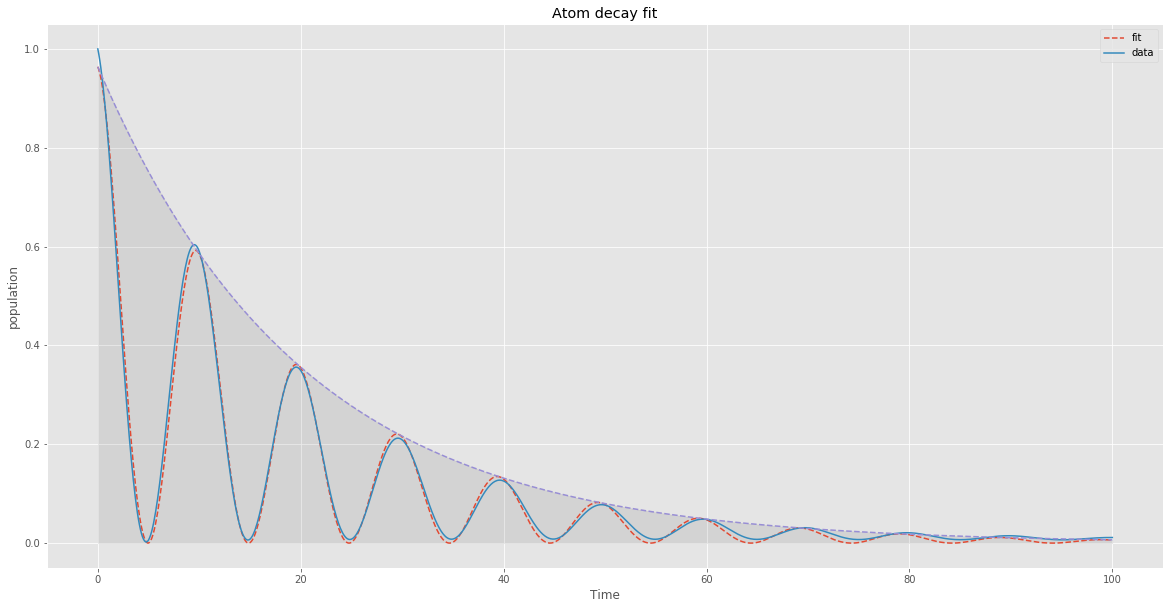

In [8]:
fit = sinexp(tlist, *popt)
# fit = sinexp(tlist, 0.5, 0.66, 0.01)
plt.figure(figsize=(20,10))
plt.plot(tlist, fit, '--', label='fit')
plt.plot(tlist, n_a, label='data')
plt.plot(tlist, np.exp(-popt[1]*tlist)*popt[2]*2, '--')
plt.fill_between(tlist, np.exp(-popt[1]*tlist)*popt[2]*2, color='black', alpha=0.08)
plt.legend()
plt.title('Atom decay fit')
plt.xlabel('Time')
plt.ylabel('population')
print('▶️ omega      = {:.3f}\n▶️ decay-rate = {:.3f}\n▶️ amplitude  = {:.3f}\n'.format(*popt))

🔹 Why the slight mismatch? Who knows 😞 Probably something with the fit function definition

In [477]:
print(f'The mean life-time of the qubit is\33[1m {1/popt[2]:.2f}\33[0m [Time units] (half-time={np.log(2)/popt[2]:0.2f})')

The mean life-time of the qubit is 2.07 [Time units] (half-time=1.44)


## Some tests - ignore 🤫

In [120]:
N = 2  # Cavity fock trunc

wa = 5 * 2 * np.pi  # cavity frequency
w0   = 5.0          # atom frequency
chi=1e5             # Coupling~ish

g2 = 1    # rate of dissipation
g1 = 0.0

# Cavity operators
a  = qt.tensor(I(2), qt.destroy(N))
ad = a.dag()
# Atom operators
b  = qt.tensor(qt.destroy(2), I(N))
bd = b.dag()

# Hamiltonian 💝
H = wa*ad*a + w0*bd*b + chi*ad*a*bd*b +  (bd+b)*10

# collapse operators
c_ops = [
    b,     # Atom collapse
#   bd,    # Atom
    b*ad   # spontunous emission
#   bd*a   # spontunous emission
]

In [121]:
# intial state
psi0 = qt.tensor(qt.basis(2,0), qt.basis(N, 0))

tlist = np.linspace(0,5,3000)

output = qt.mesolve(H, psi0, tlist, c_ops)  

psi = output.states
psit = np.array([np.array(i) for i in psi])

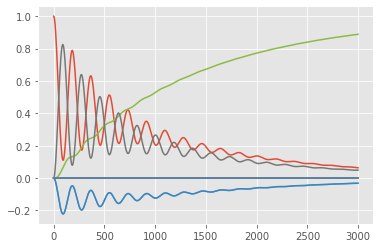

In [122]:
# An extremly inefficient way to print all of the results
for i in range(N*2):
    for j in range(N*2):
        plt.plot(np.real(psit[:,i, j]))

/home/dnl/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


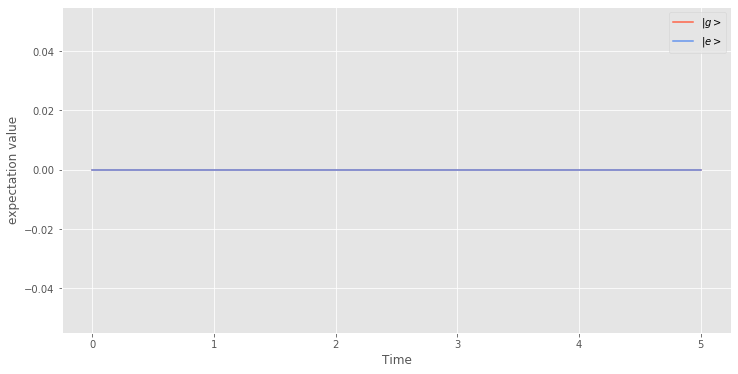

In [180]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(tlist, np.abs(psit[:,0,0]), 'tomato')
ax.plot(tlist, psit[:,0,1], 'cornflowerblue')
# ax.plot(tlist, [np.abs(psit[i,0].T.conj()@psit[i,0]) for i in range(200)], 'violet')

ax.legend((r"$|g>$", r"$|e>$"))
ax.set_xlabel('Time')
ax.set_ylabel('expectation value');

In [8]:
a = np.array(sz).reshape([1,2,2])*sz1.reshape([200,1,1])

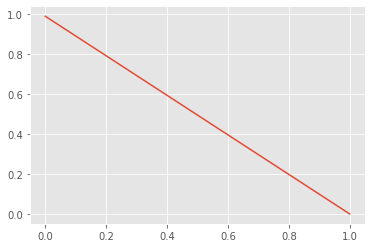

In [9]:
plt.plot(np.abs(a[1]@np.array(psi0)))

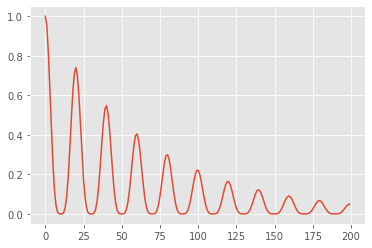

In [10]:
plt.plot([np.abs(np.array(psi0).T.conj()@i.T.conj()@i@np.array(psi0))[0,0]**2 for i in a])
plt.show()